# Social Media Analytics Assignment 2
## MSBA Spring 2018
### Ryan Conklin, Reed Dalton, Gihani Dissanayake, Ali Prasla, Jake Schmidt
<br>
<br>

In [41]:
import glob, pandas as pd
data = [{
  'date': pd.to_datetime(filename.split(' ')[0].lstrip('speeches/').strip('\\')),
  'speaker': filename.rstrip('.txt').split(' ', 1)[1],
  'text': open(filename, 'rb').readline().decode('cp1252')
} for filename in glob.glob('speeches/*.txt')]
speeches = pd.DataFrame(data)
speeches = speeches.set_index(['speaker', 'date'])
speeches.head()

text
speaker           date                                                         
George Washington 1789-04-30  Fellow Citizens of the Senate and the House of...
                  1789-10-03  Whereas it is the duty of all Nations to ackno...
                  1790-01-08  Fellow Citizens of the Senate and House of Rep...
                  1790-12-08  Fellow citizens of the Senate and House of Rep...
                  1790-12-29  I the President of the United States by my own...

# Task A
## Choose a reasonable number of topics for this corpus. One way to think about topics is to consider the number of issues that may have been important in the past as well as those that may have come up over the centuries. Provide a brief explanation of how you chose this number.

To evaluate a reasonable number of topics, we cross validated the LDA of Part B with 10, 15, 20, and 25 components/topics, the outputs are shown in the plots below. 10 topics seemed too few as the first two topics carried an unreaonably high proportion of the of the 633 speeches. Conversely, 25 components seemed to be too many, as the last 10 or so topics were highly sparse and seemed superfluous. A more ideal combination of topics is with 15 or 20 topics, at which the spreadof speeches appears more reasonably distrubted. Since they appear comparable in performance, we choose to go with the simpler option of 15 topics.

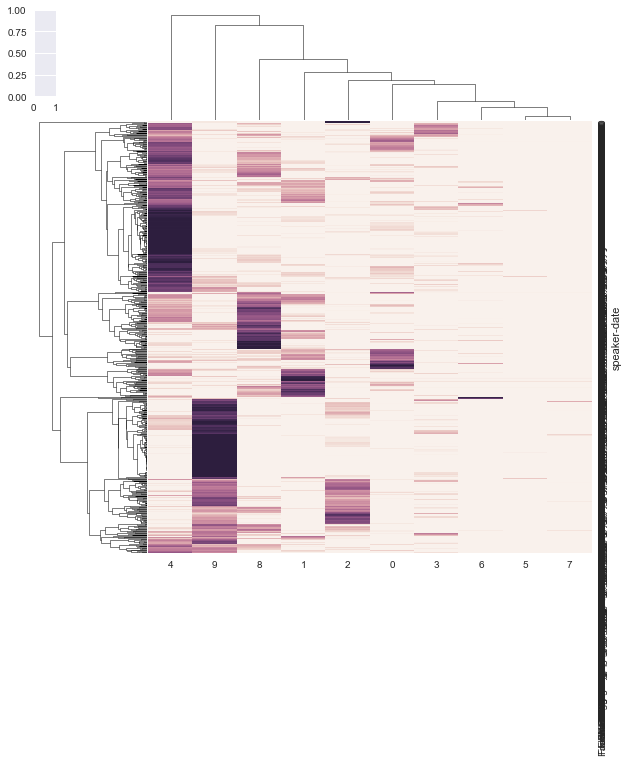

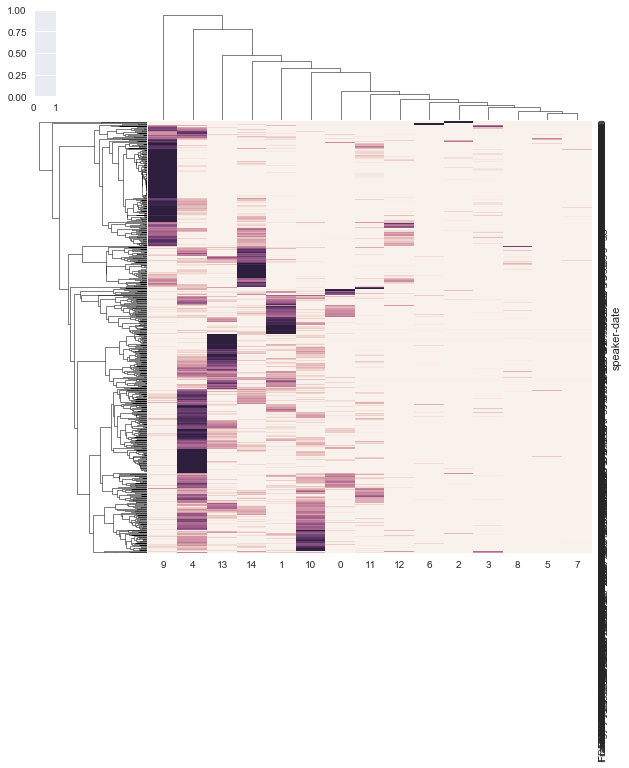

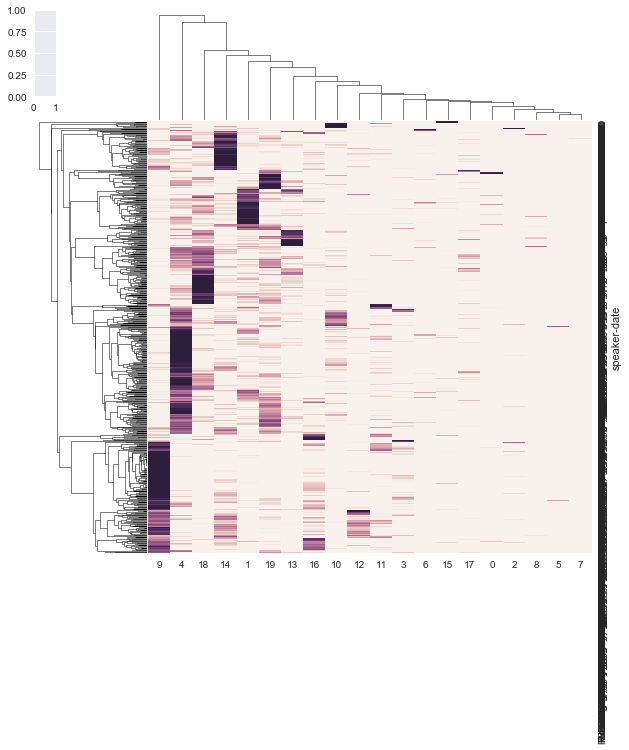

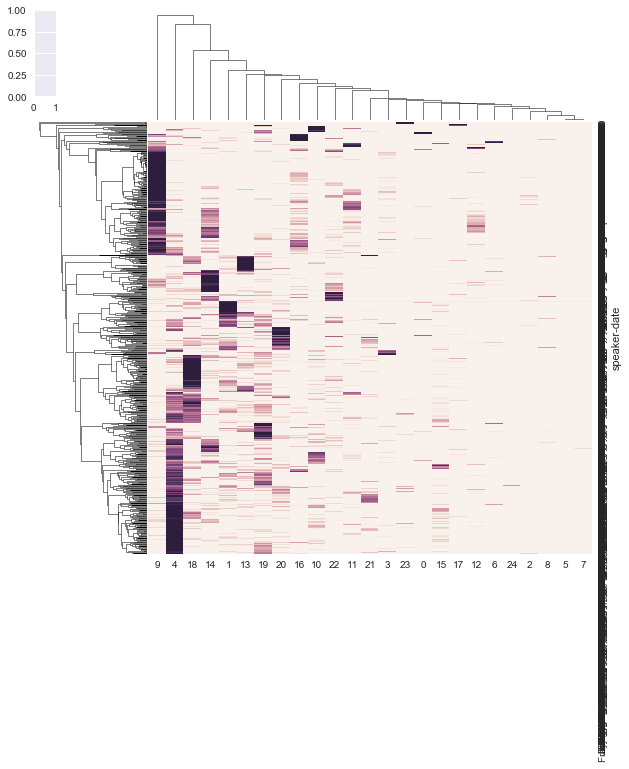

In [2]:
from IPython.display import display, Image
display(Image(filename='components10.png'))
display(Image(filename='components15.png'))
display(Image(filename='components20.png'))
display(Image(filename='components25.png'))

In [2]:
N_TOPICS = 15

# Task B
## Now perform a topic modeling exercise with LDA. Show the word distributions for each topic as well as topic distributions for each speech. Do you see any shifts over time? Explain.

In [9]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(
  CountVectorizer(stop_words='english'),
  LDA(n_components=N_TOPICS, learning_method='batch', n_jobs=-1, max_iter=25, random_state=42)
)
speech_topic = pipe.fit_transform(speeches.text)

In [10]:
import numpy as np
n_words = 10
vocab = pipe.steps[0][1].get_feature_names()
topic_words = {}
for topic, comp in enumerate(pipe.steps[1][1].components_):   
    word_idx = np.argsort(comp)[::-1][:n_words]
    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
pd.DataFrame(topic_words).T

,0,1,2,3,4,5,6,7,8,9
0,vietnam,south,president,viet,nam,north,vietnamese,think,people,war
1,president,mr,think,people,going,don,say,time,want,know
2,bank,honduras,banks,justices,rescue,circulation,paper,currency,gold,islands
3,germany,united,conference,german,government,year,great,american,poland,states
4,world,people,peace,nation,great,men,freedom,america,war,new
5,beloved,cherokees,press,gun,boats,newspaper,agent,remonstrance,cattle,information
6,lebanon,israel,country,schedule,army,tariff,middle,men,marines,union
7,thank,stirred,studied,complicated,inconceivable,interpret,familiar,immutable,haste,aspect
8,slavery,law,federal,court,union,case,statute,missouri,question,slave
9,states,government,united,congress,public,country,great,citizens,state,people


Each row above is a topic number, and the rows represent the most top 10 words for each of those topics in order.

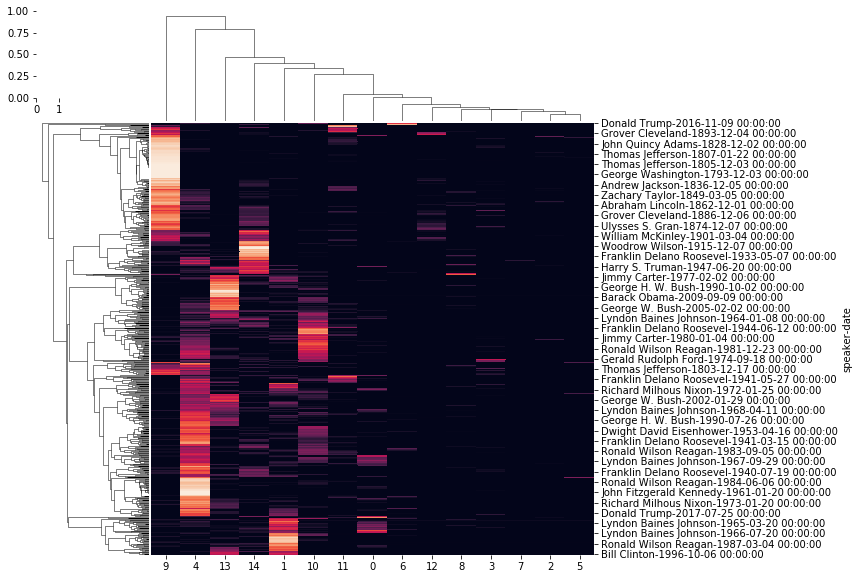

In [11]:
import matplotlib.pyplot as plt, seaborn as sns
x = pd.DataFrame(pipe.transform(speeches.text), index=speeches.index)
sns.clustermap(x, cbar=False)
plt.show()

This Cluster Map shows how topics change over time. Presidents of similiar eras have similar topics they like to discuss. For example, Topic Four is mostly associated with the 20th century presidents (with a heavy emphasis on JFK and Nixon). The top words within in this topic (Nam, Government, and Soviet amoung others) grant credence to this premise.

# Task C
## In terms of topics addressed “heavily” in a speech, which 3 former presidents does President Trump share the highest similarity with? How did you arrive at your conclusion?

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
xx = x.reset_index(1, True)
mean_topic_per_prez = xx.groupby(xx.index).mean()
similarity = pd.DataFrame(cosine_similarity(mean_topic_per_prez),index = mean_topic_per_prez.index)
similarity.columns = list(mean_topic_per_prez.index)
similarity.loc['Donald Trump'].sort_values(ascending = False)[1:4]

Jimmy Carter             0.674786
Richard Milhous Nixon    0.672095
Lyndon Baines Johnson    0.578314
Name: Donald Trump, dtype: float64

Trump is the most similar to Jimmy Carter, Richard Nixon and LBJ. We arrived at this conclusion by averaging the topic vectors for all speeches and then conducting a cosine similarity with the averaged vectors.

# Task D
## In terms of his own speeches, do you see President Trump shifting the emphasis on certain topics over time? Explain your response.

In [47]:
index = speeches.index
with_topics = pd.concat([speeches.reset_index(drop = True),pd.DataFrame(speech_topic)],axis = 1)
with_topics.index = index
trump_speeches = with_topics.reset_index(inplace = False)
trump_speeches = trump_speeches[trump_speeches.speaker == 'Donald Trump'].sort_values('date')
trump_speeches['Max_Topic'] = np.argmax(trump_speeches[list(range(N_TOPICS))].as_matrix(),axis = 1)
trump_speeches[['date','Max_Topic']]

,date,Max_Topic
625,2015-06-15,1
627,2016-09-16,1
628,2016-11-09,7
629,2017-01-20,1
630,2017-07-25,4
631,2018-01-30,1


Trump does not seem to change topics over time. Above we looked at the most important topic for each speech and there is no clear trend away from Topic One. Interestingly enough, Topic One is perhaps the most uninterpretable and incoherent topic in our data set (which aligns with our priors for the President).

# Task E
If you do a K-means clustering with the same number of clusters as topics, do you see President Trump’s speeches and those of the 3 former presidents you identified in Task C in the same cluster? What was the basis of clustering (e.g., tf-idf, cosine similarity, etc.). Discuss your findings.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Task F
Provide a visualization of both clusters (with colors) and cosine scores using MDS. 